In [2]:
import sys
sys.path.append("../../pygenesig/")

%load_ext autoreload
%autoreload 1
%aimport pygenesig.validation
%aimport pygenesig.gini
%aimport pygenesig.bioqc
%aimport pygenesig.tools
%aimport pygenesig.perfmeasures
%matplotlib inline

from pygenesig.validation import * 
from pygenesig.gini import * 
from pygenesig.bioqc import * 
from pygenesig.tools import * 
import pygenesig.perfmeasures as pm
import numpy as np
import pandas as pd
import sklearn.metrics as skm 
import os.path

import seaborn as sns
sns.set_style("ticks", {"axes.grid" : True})
from pylab import * 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Validate signatures based on FANTOM5 primary cells
This notebook aims at finding which samples from the FANTOM5 primary cells can be used to create meaningful signatures. 
We do this using cross-validation with two folds (there are often only two samples). 

When a signature is able to identify itself, the samples are 'good' and the signature appears to work. 

We first perform the crossvalidation and discard all samples that we could not validate and then re-create the signatures for the samples we did not discard. 

### Load data

In [29]:
expr_file = "../data/pygenesig/primary_exprs.npy"
target_file = "../data/pygenesig/primary_target_coarse.csv"
splitter = sklearn.model_selection.StratifiedKFold(n_splits=2)

In [ ]:
expr = np.load(expr_file)
target = np.genfromtxt(target_file,  dtype=str, delimiter=",")

### perform cross-validation

In [122]:
signatures = []
scores = []
score_mats = []
sg = GiniSignatureGenerator(expr, target, aggregate_fun=np.sum)
st = BioQCSignatureTester(expr, target)
for train, test in splitter.split(list(enumerate(target)), target):
    signature = sg.mk_signatures(train)
    score = st.score_signatures(signature, test)
    signatures.append(signature)
    sig_labels = st.sort_signatures(signature)
    scores.append(score)
    scores_df = pd.DataFrame(np.transpose(score))
    scores_df.columns = sig_labels
    scores_df['tissue'] = pd.Series(target[test])
    scores_per_sig = scores_df.groupby('tissue').mean().transpose()
    score_mats.append(scores_per_sig)

../../pygenesig/pygenesig/bioqc.py:157: RuntimeWarning: divide by zero encountered in log10
  bioqc_res_log = -np.log10(bioqc_res)


### Average the scoring matrices and visualize it

In [132]:
avg = (score_mats[0] + score_mats[1])/2

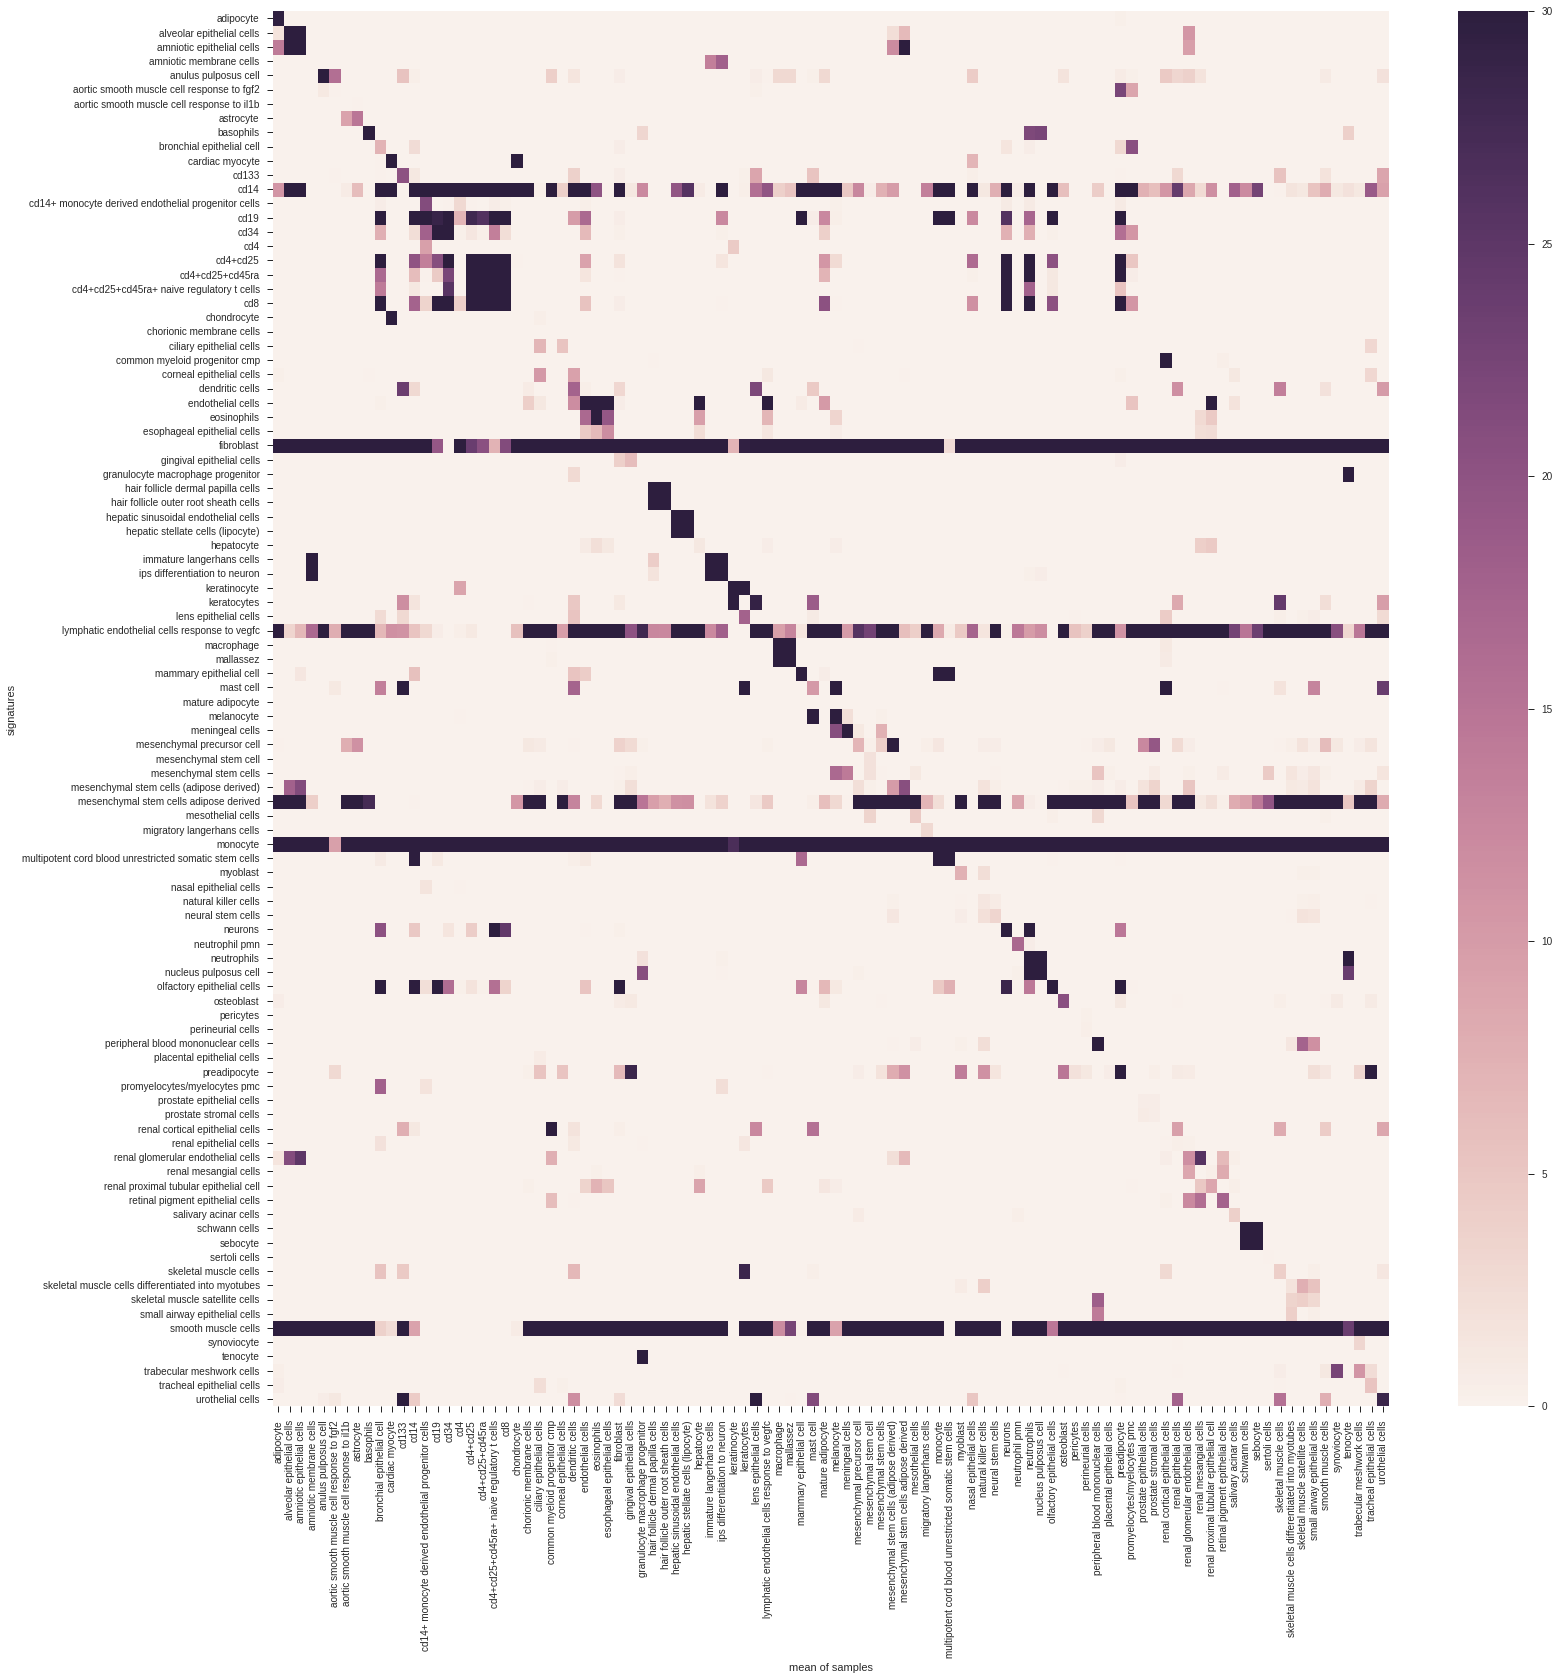

In [131]:
fig, ax = subplots(figsize=(25, 25))
sns.heatmap(avg, ax=ax, annot=False, annot_kws={"size": 9}, vmin=0, vmax=30);
ax.set_ylabel("signatures")
ax.set_xlabel("mean of samples")

In [142]:
with pd.option_context('display.max_rows', None, 'display.max_columns', 3):
    print(avg.apply(lambda x: 100 if x == float('inf') else x).apply(gini, axis=1))

ValueError: ('The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().', 'occurred at index adipocyte')